In [1]:
import torch
import cv2
import numpy as np
import os
from PIL import Image
from scene.colmap_loader import read_points3D_binary, read_extrinsics_binary, read_intrinsics_binary, qvec2rotmat

In [2]:
dataset_path = "dataset"

Depth estimation

In [ ]:
repo = "isl-org/ZoeDepth"
# Zoe_N
model_zoe_n = torch.hub.load(repo, "ZoeD_N", pretrained=True).to("cuda")

In [ ]:

os.makedirs(os.path.join(dataset_path,"depth"), exist_ok=True)

for image in os.listdir(os.path.join(dataset_path,"images")):
    # if it is not an image, skip
    if not (image.endswith(".jpg") or image.endswith(".png")):
        continue
    img = Image.open(os.path.join(dataset_path, "images", image))
    depth = model_zoe_n.infer_pil(img)
    depth = (depth*50).astype(np.uint8)
    depth = Image.fromarray(depth)
    depth.save(os.path.join(dataset_path, "depth", image.split(".")[0]+".png"))
    print("Saved", image.split(".")[0]+".png")

Extract point cloud

In [4]:
points3D_path = os.path.join(dataset_path,"sparse","0", "points3D.bin")
os.path.exists(points3D_path)
xyz, rgb, errors = read_points3D_binary(points3D_path)

In [8]:
errors.min()

0.00026029333173103005

Extract cameras

In [22]:
cameras_intrinsic_file = os.path.join(dataset_path, "sparse/0", "cameras.bin")
cameras_extrinsic_file = os.path.join(dataset_path, "sparse/0", "images.bin")

cam_extrinsics = read_extrinsics_binary(cameras_extrinsic_file)
cam_intrinsics = read_intrinsics_binary(cameras_intrinsic_file)

In [50]:
def create_extrinsic_matrix(extrinsic):
    """
    Create a 4x4 extrinsic matrix from a quaternion and translation vector.
    """
    rotation_matrix = qvec2rotmat(extrinsic.qvec)
    extrinsic_matrix = np.eye(4)
    extrinsic_matrix[:3, :3] = rotation_matrix
    extrinsic_matrix[:3, 3] = extrinsic.tvec
    return extrinsic_matrix

def create_intrinsic_matrix(intrinsic):

    intrinsic_matrix = np.eye(4)
    intrinsic_matrix[0, 0] = intrinsic.params[0]
    intrinsic_matrix[1, 1] = intrinsic.params[1]
    intrinsic_matrix[0, 2] = intrinsic.params[2]
    intrinsic_matrix[1, 2] = intrinsic.params[3]
    
    return intrinsic_matrix

def project_points(points, intrinsics):
    # Assuming points is an Nx4 numpy array and intrinsics is a 4x4 matrix
    projected_points = intrinsics @ points.T
    projected_points /= projected_points[2, :]
    return projected_points.T

In [45]:
extrinsic = cam_extrinsics[1]
points_homogeneous = np.hstack([xyz, np.ones((xyz.shape[0], 1))])
extrinsic_matrix = create_extrinsic_matrix(extrinsic)
transformed = extrinsic_matrix @ points_homogeneous.T
transformed = transformed.T

In [53]:
intrinsic = cam_intrinsics[1]
intrinsic_matrix = create_intrinsic_matrix(intrinsic)
projected = project_points(transformed, intrinsic_matrix)

In [65]:
extrinsic.name

'0001.jpg'

In [72]:
#img = np.zeros((intrinsic.height, intrinsic.width, 3), dtype=np.uint8)
img = cv2.imread(os.path.join(dataset_path, "input", extrinsic.name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for point in projected:
    x, y = point[0], point[1]
    if 0 <= x < intrinsic.width and 0 <= y < intrinsic.height:
        cv2.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)

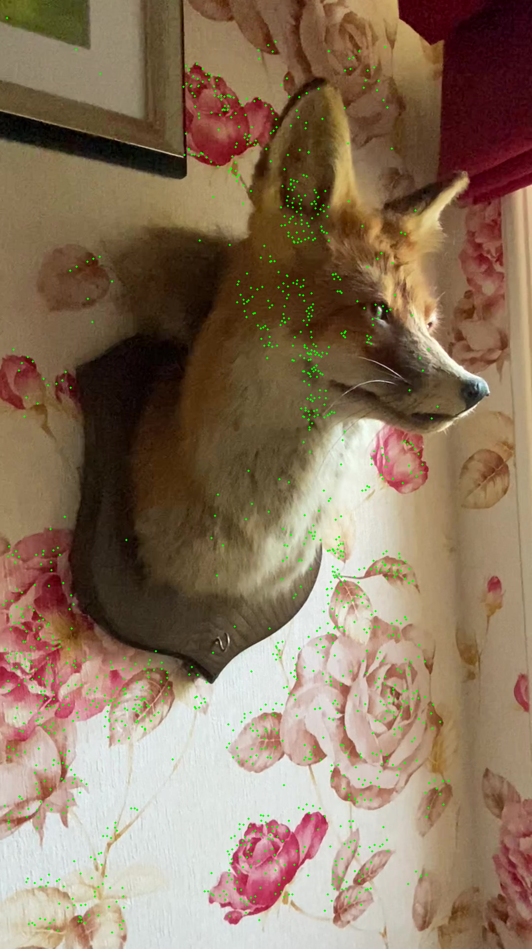

In [73]:
Image.fromarray(img).resize((intrinsic.width//2, intrinsic.height//2))

In [41]:
from depth_regularization.proj_utils import create_depth_maps, project_points_to_cameras
import cv2
import numpy as np
import os

dataset_path = "dataset"
depth_maps = create_depth_maps(dataset_path)

cam_intrinsics, cam_extrinsics, projected_points, transformed_points, rgb, error = project_points_to_cameras(dataset_path)

# Index extrinsics with image name instead
extrinsics = {}
for cam in cam_extrinsics.values():
    extrinsics[cam.name] = cam

intrinsic = cam_intrinsics[1]

reliability = 1/error

min = np.percentile(reliability, 5)
max = np.percentile(reliability, 95)

weight = (reliability - min) / (max - min)
weight = np.clip(weight, 0, 1).reshape(-1)

Using cache found in /home/pablo/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /home/pablo/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully
Created depth map for:  0035
Created depth map for:  0108
Created depth map for:  0026
Created depth map for:  0072
Created depth map for:  0115
Created depth map for:  0085
Created depth map for:  0009
Created depth map for:  0001
Created depth map for:  0089
Projected points for camera:  9
Projected points for camera:  8
Projected points for camera:  7
Projected points for camera:  6
Projected points for camera:  5
Projected points for camera:  4
Projected points for camera:  3
Projected points for camera:  2
Projected points for camera:  1


In [45]:
depth_map = "0001.jpg"
id = extrinsics[depth_map].camera_id
projected = projected_points[id][:,:2]

# Scale projected points to depth map size
scale_ratio = intrinsic.width / depth_maps[depth_map].shape[1]
projected = projected / scale_ratio

index = np.zeros((projected.shape[0], 2), dtype=np.int32)
index[:, 1] = np.int32(np.clip(projected[:, 0], 0, intrinsic.width - 1))
index[:, 0] = np.int32(intrinsic.height - 1 - np.clip(projected[:, 1], 0, intrinsic.height - 1))

depth_map_points = depth_maps[depth_map][index[:, 0], index[:, 1]]

Find scale and offset

In [58]:
from scipy.optimize import minimize

In [80]:
def function_to_minimize(x):
    scale, offset = x
    return np.sum((weight * transformed_points[1][:, 2] - (depth_map_points * scale + offset))**2)

In [108]:
samples = 100

scale = np.linspace(0.5, 1.5, samples)
offset = np.linspace(-0.5, 0.5, samples)

X, Y = np.meshgrid(scale, offset)

Z = np.zeros((samples, samples))

for i in range(samples):
    for j in range(samples):
        Z[i, j] = function_to_minimize([X[i, j], Y[i, j]])

Z.min()

5349.557814749177

In [109]:
min_index = np.argmin(Z)
i_min, j_min = np.unravel_index(min_index, Z.shape)

# Get the corresponding scale and offset values
optimal_scale = X[i_min, j_min]
optimal_offset = Y[i_min, j_min]

In [112]:
diff = weight * transformed_points[1][:, 2] - (depth_map_points * optimal_scale + optimal_offset)

In [114]:
diff.mean()

0.008358338330415858